In [260]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [304]:
state = 'Michigan'


def pred_stat(state, stat, time_step=6, batch_size=16, drop_level=0.2, plot_or_not=0):
    weather = pd.read_csv(f'collated_data/{state}.csv')
    weather['Date'] = pd.to_datetime(weather['Date'].astype(str), format='%Y%m')
    weather['Date'] = weather['Date'] + pd.offsets.MonthEnd(0)
    weather.set_index('Date', inplace=True)
    weather = weather.asfreq('ME')

    l = ['tavg']
    l.append(stat)

    data = weather[l].values
    X, y = [], []

    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, [1, 0]]) 
        y.append(data[i + time_step, 1])
    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    scalers = {col: MinMaxScaler(feature_range=(0, 1)) for col in l}
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    
    X_train_scaled = np.zeros_like(X_train)
    X_test_scaled = np.zeros_like(X_test) 
    
    for i, col in enumerate(l):
        X_train_scaled[:, :, i] = scalers[col].fit_transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1])
        X_test_scaled[:, :, i] = scalers[col].transform(X_test[:, :, i].reshape(-1, 1)).reshape(X_test.shape[0], X_test.shape[1])
    
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

    model = Sequential()

    model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(drop_level))
    
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(drop_level))
    
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=batch_size, validation_data=(X_test_scaled, y_test_scaled), verbose=0)

    test_loss = model.evaluate(X_test_scaled, y_test_scaled)
    print(f'Test Loss: {test_loss}')

    predictions = model.predict(X_test_scaled)

    predictions_inv_scaled = scaler_y.inverse_transform(predictions)
    y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_inv_scaled))
    
    if plot_or_not==1:
        print(rmse)
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_actual, color='blue', label=f'Actual {stat}') 
        plt.plot(predictions_inv_scaled, color='red', label=f'Predicted {stat}') 
        plt.title(f'{state} CDD: Actual vs Predicted', fontsize=16)
        # plt.xlabel('Time', fontsize=12)
        # plt.ylabel('', fontsize=12)
        plt.legend()
        plt.show()   
    else:
        return rmse


In [276]:
drop_level = [0.1, 0.2]
batch_size = [16, 32, 64]
time_step = [1, 3, 6]
stat = ['cdd', 'hdd']

rmse_cdd = -1
rmse_hdd = -1
for d in drop_level:
    for b in batch_size:
        for t in time_step:
            rmse_1 = pred_stat(state, 'cdd', t, b, d)
            rmse_2 = pred_stat(state, 'hdd', t, b, d)
            
            if rmse_cdd == -1:
                rmse_cdd = (t, b, d, rmse_1)
            if rmse_hdd == -1:
                rmse_hdd = (t, b, d, rmse_2)
            if rmse_cdd[3] > rmse_1:
                rmse_cdd = (t, b, d, rmse_1)
            if rmse_hdd[3] > rmse_2:
                rmse_hdd = (t, b, d, rmse_2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0305
Test Loss: 0.03300831839442253
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0288
Test Loss: 0.028335029259324074
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0125
Test Loss: 0.012262585572898388
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0103
Test Loss: 0.009461287409067154
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0089
Test Loss: 0.00913494173437357
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0051
Test Loss: 0.004709591157734394
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0304
Test Loss: 0.03292899578809738
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0290
Test Loss: 0.02860860526561737
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
2/2 ━━━━━━━━

In [280]:
print(f"CDD RMSE Best = {rmse_cdd[3]} at Timestep = {rmse_cdd[0]}, Batch Size = {rmse_cdd[1]}, Dropout = {rmse_cdd[2]}")
print(f"HDD RMSE Best = {rmse_hdd[3]} at Timestep = {rmse_hdd[0]}, Batch Size = {rmse_hdd[1]}, Dropout = {rmse_hdd[2]}")

CDD RMSE Best = 33.4519114550909 at Timestep = 6, Batch Size = 16, Dropout = 0.1
HDD RMSE Best = 104.5019898928779 at Timestep = 6, Batch Size = 32, Dropout = 0.1


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0092
Test Loss: 0.009349469095468521
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
33.842427275089435


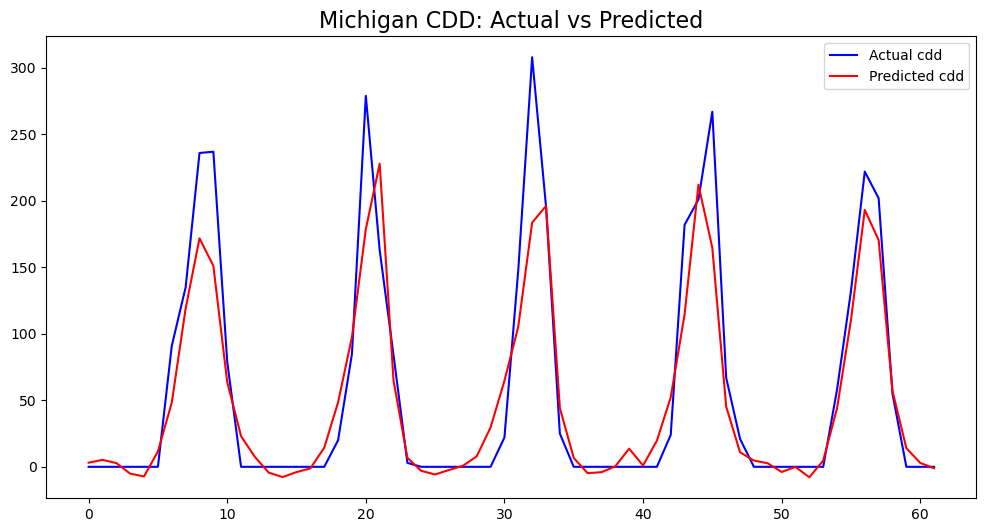

In [306]:
pred_stat(state, 'cdd', 6, 16, 0.1, 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0047
Test Loss: 0.004479493014514446
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
103.60611099469887


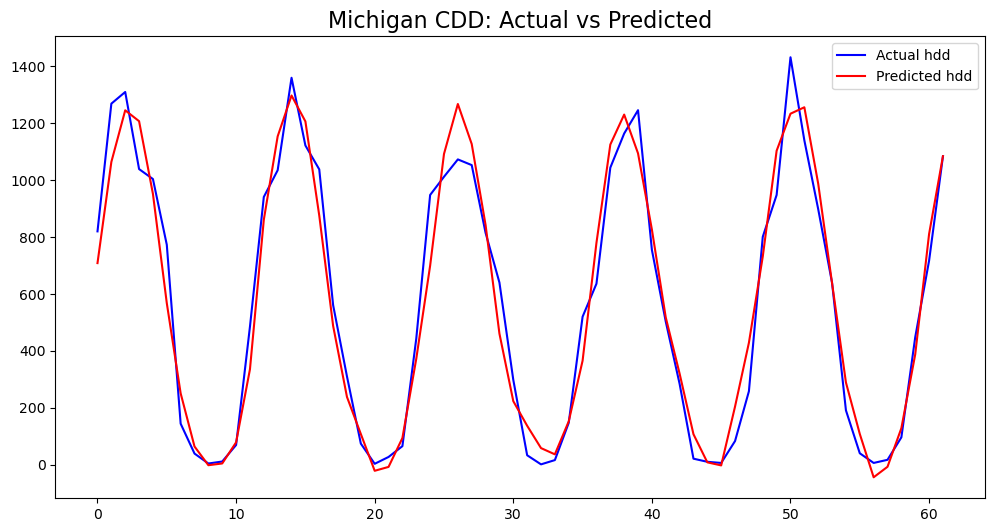

In [307]:
pred_stat(state, 'hdd', 6, 32, 0.1, 1)